In [1]:
# Basic imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# For presentation purposes we'll hide warnings that may arise from our models (i.e. convergence warnings).
import warnings
warnings.filterwarnings('ignore')

# Data processing

We start by importing our processed data, dropping columns unhelpful for classification, and separating the features from the target column.

In [3]:
dnd = pd.read_csv("dnd_monsters_processed.csv").drop(columns=["Index", "name"])
features = dnd.drop(columns=["cr"])
target = dnd.cr

Here's what the complete dataset looks like.

In [4]:
dnd

,size,type,alignment,ac,hp,cr,speed,swim,climb,fly,burrow,strength,dex,con,intel,wis,cha,legendary
0,2,0,0,12.0,13,0.25,20,0,0,50,0,10,14,10,11,12,11,0
1,2,1,1,12.0,84,9.00,30,0,0,0,0,9,14,14,18,12,11,0
2,3,2,2,17.0,135,10.00,10,40,0,0,0,21,9,15,18,15,18,1
3,4,3,3,15.0,137,9.00,40,0,40,0,0,24,10,22,9,13,9,0
4,2,4,4,21.0,285,23.00,30,0,0,0,0,13,16,20,27,21,20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757,2,70,4,11.0,40,1.00,30,0,0,0,0,11,12,11,13,12,14,0
758,5,7,8,21.0,307,22.00,40,40,0,0,0,30,10,30,2,21,18,0
759,3,11,2,21.0,580,26.00,50,0,0,150,0,27,24,28,26,27,30,1
760,2,4,4,8.0,22,0.25,20,0,0,0,0,13,6,16,3,6,5,0


Here's a visual for how many monsters are in each challenge rating class.

<AxesSubplot:title={'center':'Count of Challenge Ratings'}, xlabel='Challenge Ratings', ylabel='Count'>

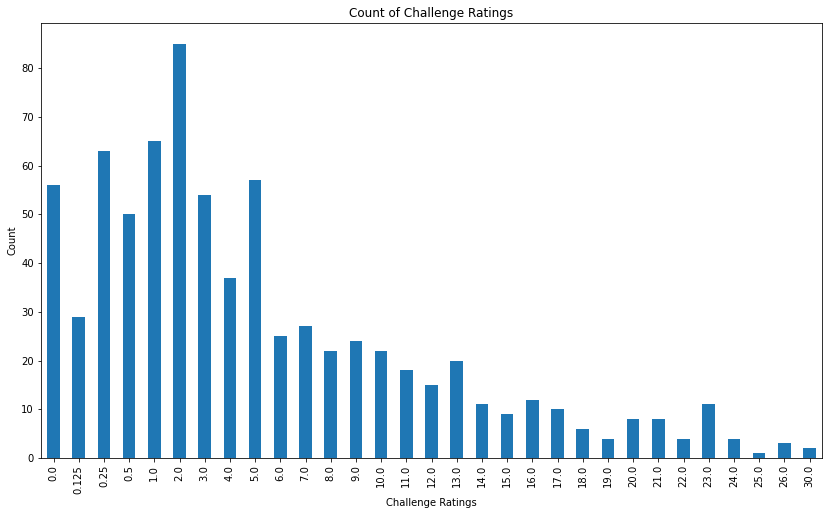

In [18]:
ax = dnd.cr.value_counts().sort_index().plot(kind='bar', figsize=(14,8),title="Count of Challenge Ratings")
ax.set_xlabel("Challenge Ratings")
ax.set_ylabel("Count")
ax

For our machine learning models we'll need to convert the features and targets to numpy arrays.

In [6]:
X = features.to_numpy()
y = target.to_numpy()

Since not all models can take real-numbered targets, we also create a shifted target vector that converts the fractional challenge ratings the lowest-valued integers and shift the rest of the challenge ratings to accommodate them.

In [7]:
y_shift = []
for i in y:
    if i == .125:
        y_shift.append(1)
    elif i == .25:
        y_shift.append(2)
    elif i == .5:
        y_shift.append(3)
    else:
        y_shift.append(i+3)

In addition to using the whole dataset, we thought that it would be interesting to partition the dataset into different categories and test how much influence each category had. When examining the data, three main partitions stood out: general traits, mobility capabilities, and ability scores. To examine their individual impacts we created an array of modified observations with different combinations of these categories.

In [8]:
traits = ["size", "type", "alignment", "legendary"]
mobility = ["speed", "swim", "climb", "fly", "burrow"]
abilityscore = ["ac", "hp","strength", "dex", "con", "intel", "wis", "cha"]

names = ["No traits", "No mobility", "No ability score", "Only traits", "Only mobility", "Only ability score"]
X_mod = [features.drop(columns=traits)]
X_mod.append(features.drop(columns=mobility))
X_mod.append(features.drop(columns=abilityscore))
X_mod.append(features.drop(columns=mobility+abilityscore))
X_mod.append(features.drop(columns=abilityscore+traits))
X_mod.append(features.drop(columns=traits+mobility))

# Testing Tools

To run our experiments, we created a helper function that takes a model, the observations, target values, and a number of trials to run. This allowed us to easily run experiments per model and find an average score for them.

In [9]:
def test_model(model, X, y, trials):
    test = []
    train = []
    for i in range(trials):
        X_train, X_test, y_train, y_test = train_test_split(X, y)    
        model.fit(X_train, y_train)
        test.append(model.score(X_test, y_test))
        train.append(model.score(X_train, y_train))

    print("Accuracy on training set: {:.5f}".format(np.mean(train)))
    print("Accuracy on test set: {:.5f}".format(np.mean(test)))

Similarly, we create a helper function to test how the model performs when using the various feature partitions.

In [21]:
def test_model_mod(model, names, X, y, trials):
    for i in range(len(names)):
        print(names[i])
        test_model(model, X[i], y, 100)
        print()

For each model family, we start by running the test_model function on all the features to create a baseline for expected accuracy. We then run the model against the different feature partitions to see what changes. 

# KNN Classification and Regression

As a baseline, we first started by trying to use knn classification and regression schemes. Since knn models cannot use continuous target values, we had to use the shifted targets. Starting with knn classification, we see that it wasn't very effective.

In [11]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(15)
test_model(knn, X, y_shift, 100)

Accuracy on training set: 0.39797
Accuracy on test set: 0.27963


But when using the knn regression model, we find that it works much better.

In [12]:
from sklearn.neighbors import KNeighborsRegressor
knn_reg = KNeighborsRegressor(15)
test_model(knn_reg, X, y_shift, 100)

Accuracy on training set: 0.91587
Accuracy on test set: 0.89903


Since regression is more appropriate for determining challenge rating, we choose to focus on regression model families for the rest of our experiments. Let's examine what happens when we use the modified features on the knn regressor.

In [13]:
knn_reg = KNeighborsRegressor(15)
test_model_mod(knn_reg, names, X_mod, y_shift, 100)

No traits
Accuracy on training set: 0.91818
Accuracy on test set: 0.90754

No mobility
Accuracy on training set: 0.92048
Accuracy on test set: 0.90785

No ability score
Accuracy on training set: 0.32980
Accuracy on test set: 0.21303

Only traits
Accuracy on training set: 0.47029
Accuracy on test set: 0.38437

Only mobility
Accuracy on training set: 0.22819
Accuracy on test set: 0.16254

Only ability score
Accuracy on training set: 0.92253
Accuracy on test set: 0.91313



# Linear Regression

Our next set of tests uses the linear regression model. This ran much faster compared to knn regression, but had a slight hit to accuracy.

In [14]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
test_model(lr, X, y, 100)

Accuracy on training set: 0.90514
Accuracy on test set: 0.89237


And now for the modified features.

In [19]:
lr = LinearRegression()
test_model_mod(lr, names, X_mod, y, 100)

No traits
Accuracy on training set: 0.90315
Accuracy on test set: 0.89444

No mobility
Accuracy on training set: 0.90017
Accuracy on test set: 0.89078

No ability score
Accuracy on training set: 0.45273
Accuracy on test set: 0.43601

Only traits
Accuracy on training set: 0.42947
Accuracy on test set: 0.41506

Only mobility
Accuracy on training set: 0.20143
Accuracy on test set: 0.17437

Only ability score
Accuracy on training set: 0.89979
Accuracy on test set: 0.89093



# MLP Regression

We then used a multilevel perception model. This was the slowest to run of them all, so we had to reduce the number of trials to get results in a reasonable amount of time, but it had the most accuracy overall.

In [16]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor()
test_model(mlp, X, y, 10)

Accuracy on training set: 0.94966
Accuracy on test set: 0.91609


And once again, modified features.

In [17]:
mlp = MLPRegressor()
test_model_mod(mlp, names, X_mod, y, 10)

No traits
Accuracy on training set: 0.94382
Accuracy on test set: 0.91577

No mobility
Accuracy on training set: 0.94286
Accuracy on test set: 0.92739

No ability score
Accuracy on training set: 0.53179
Accuracy on test set: 0.44615

Only traits
Accuracy on training set: 0.51153
Accuracy on test set: 0.48367

Only mobility
Accuracy on training set: 0.24883
Accuracy on test set: 0.17777

Only ability score
Accuracy on training set: 0.93582
Accuracy on test set: 0.92403



# Conclusions

*insert conclusion here*